## Kaggle Titanic dataset
[Kaggle Titanic](https://www.kaggle.com/c/titanic) Machine Learning challenge with scikit-learn model selection tools


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Loading training dataset

# survival	  Survival - target variable                    0 = No, 1 = Yes
# pclass	    Ticket class	                                1 = 1st, 2 = 2nd, 3 = 3rd
# sex	        Sex	
# Age	        Age in years	
# sibsp	      # of siblings / spouses aboard the Titanic	
# parch	      # of parents / children aboard the Titanic	
# ticket	    Ticket number	
# fare	      Passenger fare	
# cabin	      Cabin number	
# embarked	  Port of Embarkation	                          C = Cherbourg, Q = Queenstown, S = Southampton

df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 1.1 Preparing the data

In [ ]:
# Feature Engineering
# Variable Title
# Extracting titles such as Mr. and Mrs. from variable Name
df['Title'] = np.array([re.search('([A-Za-z]+)\.', name)[0] for name in df['Name']])
df['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64

In [ ]:
df.loc[(df['Title'] != 'Mr.') & (df['Title'] != 'Miss.') & (df['Title'] != 'Mrs.') & (df['Title'] != 'Master.'), 'Title'] = 'Other'
df['Title'].value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Title, dtype: int64

In [ ]:
# Dropping variable Name
df.drop(columns = 'Name', inplace = True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.


In [ ]:
# Variable Deck
# Assigning 'Unknown' to NAs
# Creating variable Deck with cabin letters
df['Cabin'].fillna('Unknown', inplace = True)
df['Deck'] = [re.search('([A-Z])', cabin)[0] for cabin in df['Cabin']]
df['Deck'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

In [ ]:
# Dropping variable Cabin
df.drop(columns = 'Cabin', inplace = True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr.,U
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs.,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.,U
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Mrs.,C
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Mr.,U


In [ ]:
# Recoding ticket variable to identify how many passengers shared the same ticket
for ticket, count in zip(df['Ticket'].value_counts().index.tolist(), df['Ticket'].value_counts().tolist()):
  df['Ticket'].replace(to_replace = ticket, value = count, inplace = True)
df['Ticket'].value_counts()

1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: Ticket, dtype: int64

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck
0,1,0,3,male,22.0,1,0,1,7.2500,S,Mr.,U
1,2,1,1,female,38.0,1,0,1,71.2833,C,Mrs.,C
2,3,1,3,female,26.0,0,0,1,7.9250,S,Miss.,U
3,4,1,1,female,35.0,1,0,2,53.1000,S,Mrs.,C
4,5,0,3,male,35.0,0,0,1,8.0500,S,Mr.,U


In [ ]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
# Duplicated Rows
sum(df.duplicated())

0

In [ ]:
# Dropping PassengerId variable
df.drop(columns = 'PassengerId', inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
 9   Title     891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


### 1.2 Missing values

In [ ]:
df_encoded = pd.get_dummies(df, columns = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck'], drop_first = True)
df_encoded.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0,22.0,1,0,1,7.2500,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,1,71.2833,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1,26.0,0,0,1,7.9250,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
4,0,35.0,0,0,1,8.0500,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Imputation with K-Nearest-Neighbors Imputer
imputer = KNNImputer(n_neighbors = 5, weights = "uniform")

df_complete = imputer.fit_transform(df_encoded)
df_complete = pd.DataFrame(df_complete, columns = df_encoded.columns.values)
df_complete.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,22.0,1.0,0.0,1.0,7.2500,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,1.0,71.2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,26.0,0.0,0.0,1.0,7.9250,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,2.0,53.1000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,35.0,0.0,0.0,1.0,8.0500,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    float64
 3   Parch        891 non-null    float64
 4   Ticket       891 non-null    float64
 5   Fare         891 non-null    float64
 6   Pclass_2     891 non-null    float64
 7   Pclass_3     891 non-null    float64
 8   Sex_male     891 non-null    float64
 9   Embarked_Q   891 non-null    float64
 10  Embarked_S   891 non-null    float64
 11  Title_Miss.  891 non-null    float64
 12  Title_Mr.    891 non-null    float64
 13  Title_Mrs.   891 non-null    float64
 14  Title_Other  891 non-null    float64
 15  Deck_B       891 non-null    float64
 16  Deck_C       891 non-null    float64
 17  Deck_D       891 non-null    float64
 18  Deck_E       891 non-null    float64
 19  Deck_F  

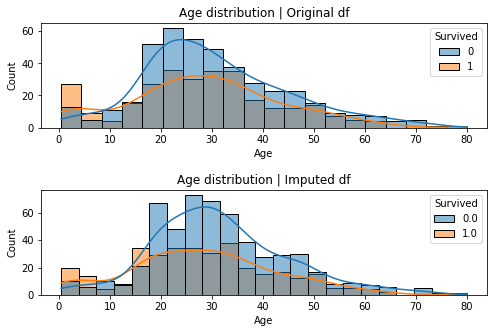

In [ ]:
# Checking quality of imputations on 'Age' variable
fig = plt.figure(figsize=(8, 5))

plt.subplot(2, 1, 1)
sns.histplot(data = df, x = 'Age', hue = "Survived", kde = True).set_title('Age distribution | Original df')

plt.subplot(2, 1, 2)
sns.histplot(data = df_complete, x = 'Age', hue = "Survived", kde = True).set_title('Age distribution | Imputed df')

plt.subplots_adjust(hspace = 0.6)
plt.show()

In [ ]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [ ]:
df_complete['Age'].describe()

count    891.000000
mean      30.210274
std       13.707090
min        0.420000
25%       21.000000
50%       29.700000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

> Imputation preserved variable distribution across groups

### 1.3 Exploratory Data Analysis

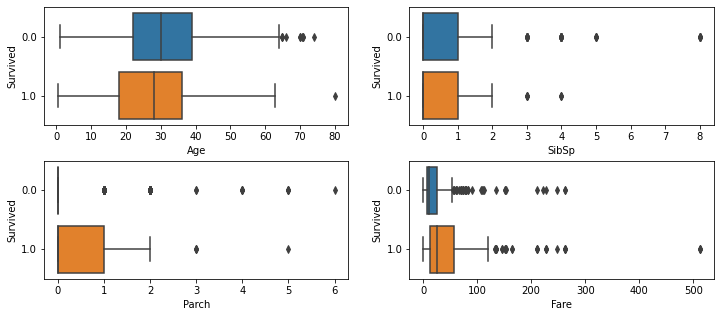

In [ ]:
# Univariate check for outliers
df_num = ['Age', 'SibSp', 'Parch', 'Fare']

# Boxplots
a = 2 # Rows
b = 2 # Columns
c = 1 # Plot counter initialization

fig = plt.figure(figsize=(12, 5))

for var in df_num:
  plt.subplot(a, b, c)
  plt.xlabel('')
  sns.boxplot(data = df_complete, x = var, y = "Survived", orient = "h")
  c += 1

plt.subplots_adjust(hspace = 0.3)
plt.show()

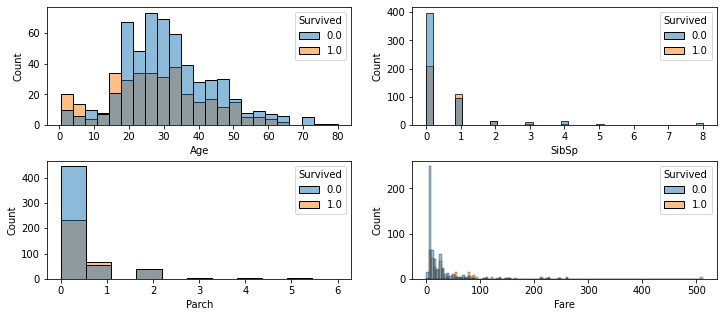

In [ ]:
# Histograms
fig = plt.figure(figsize=(12, 5))
c = 1

for var in df_num:
  plt.subplot(a, b, c)
  plt.xlabel('')
  sns.histplot(data = df_complete, x = var, hue = "Survived")
  c += 1

plt.subplots_adjust(hspace = 0.3)
plt.show()

> Univariate outlier check shows possible outliers at Fare > 500.

In [ ]:
df_complete.loc[df_complete['Fare'] > 500, 'Fare'].count()

3

In [ ]:
df_complete.loc[df_complete['Fare'] > 500, :]

,Survived,Age,SibSp,Parch,Ticket,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
258,1.0,35.0,0.0,0.0,3.0,512.3292,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
679,1.0,36.0,0.0,1.0,3.0,512.3292,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737,1.0,35.0,0.0,0.0,3.0,512.3292,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> It seems that these same passengers boarded together (with same ticket) on first class, therefore the high Fare is reasonable. Variable will be kept unchanged.

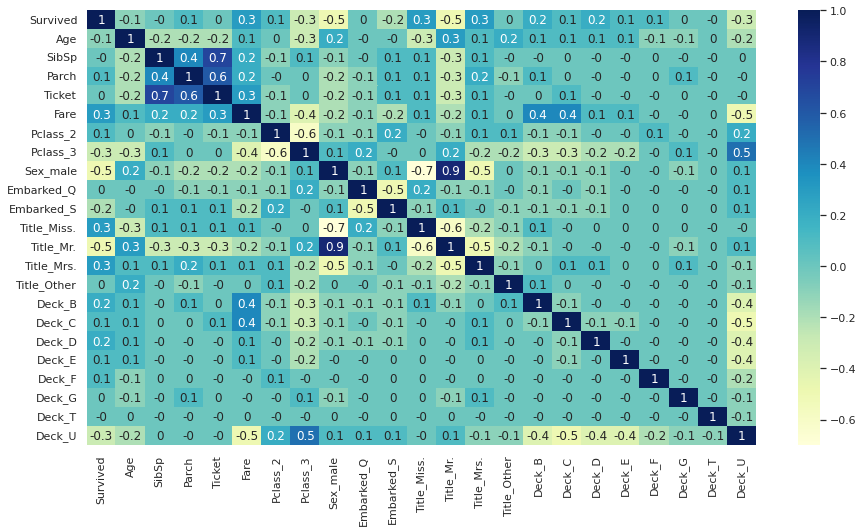

In [ ]:
# Correlation matrix
sns.set(rc = {'figure.figsize': (15, 8)})
sns.heatmap(round(df_complete.corr(), 1), annot=True, cmap="YlGnBu")
plt.show()

- Correlation matrix shows that sex is (expectedly) correlated to some of the title variables.
- Fare also correlates to decks B and C, as awell as negatively correlates to deck 'Unknown' and Pclass_3 (also expected).
- Passengers with siblings and spouses are correlated to Ticket variable, showing that families generally held the same tickets (also expected).
- Gender related variables seems to be the most important features for predicting target variable Survived.

In [ ]:
# Defining training and test sets
# X = df_complete.drop(columns = 'Survived')
# y = df_complete['Survived']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

# print(f'Training features shape: {X_train.shape}')
# print(f'Test features shape: {X_test.shape}')

In [ ]:
# Feature selection
features = ['Age', 'Ticket', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
            'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Other', 'Deck_B', 
            'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U']

X = df_complete[features]
y = df_complete['Survived']

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

print(f'Training features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}')

Training features shape: (668, 18)
Test features shape: (223, 18)


### 1.4 Solvers

In [ ]:
# Logistic Regression
max_iter = 3000
logr = LogisticRegression(max_iter = max_iter, penalty = 'elasticnet', solver = 'saga', random_state = 123)

# Random Forest Classifier
rfor = RandomForestClassifier(criterion = 'gini', bootstrap = True, n_jobs = -1, random_state = 123,
                              min_samples_split= 0.3, min_samples_leaf = 0.1)

# Support Vector Classifier
svc = SVC(max_iter = -1, probability = True, random_state = 123)

# Pipeline
# Standandardizing by mean and unit variance
logr_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("logr", logr)])
rfor_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("rfor", rfor)])
svc_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("svc", svc)])

# Cross-validation method
KFcv = KFold(n_splits = 5, shuffle = True, random_state = 123)

#### 1.4.1 Logistic Regression

In [ ]:
np.random.seed(123)
param_grid = {
    # Logistic scale for C parameter with 1000 values
    "logr__C": [C for C in np.linspace(1.8, 2.4, 100)],
    "logr__l1_ratio": [round(n, 1) for n in np.linspace(0.8, 1, 10)]
}

search = RandomizedSearchCV(logr_pipeline, param_grid,
                            n_iter = 100,                 # 100 random iterations over param_grid                    
                            n_jobs = -1,                  # Parallelized run
                            cv = KFcv,                    # K-fold cross-validation
                            random_state = 123)

search.fit(X_train, y_train)

print("Logistic Regression best parameter (CV score=%0.3f):" % search.best_score_)
print("Logistic Regression best parameters:", search.best_params_)

Logistic Regression best parameter (CV score=0.807):
Logistic Regression best parameters: {'logr__l1_ratio': 0.9, 'logr__C': 2.1515151515151514}


In [ ]:
logr_search = pd.DataFrame(search.cv_results_)[['param_logr__C', 'param_logr__l1_ratio', 'mean_test_score']]
logr_search.sort_values('mean_test_score', ascending = False).head()

,param_logr__C,param_logr__l1_ratio,mean_test_score
28,2.333333,0.8,0.80698
66,2.272727,0.9,0.80698
76,2.387879,0.8,0.80698
75,2.187879,0.8,0.80698
30,2.236364,0.8,0.80698


In [ ]:
# Optimized Logistic Regression
logr = LogisticRegression(max_iter = max_iter,
                          C = 2.333333,
                          penalty = 'elasticnet',
                          l1_ratio = 0.8,
                          solver = 'saga',
                          random_state = 123)

# Pipeline
# Standandardizing by mean and unit variance
logr_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("logr", logr)])

# Train Logistic Regressor
logr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logr',
                 LogisticRegression(C=2.333333, l1_ratio=0.8, max_iter=3000,
                                    penalty='elasticnet', random_state=123,
                                    solver='saga'))])

In [ ]:
# Logistic Regression performance
Train_Accuracy = logr_pipeline.score(X_train, y_train)
Test_Accuracy = logr_pipeline.score(X_test, y_test)

print("Train Accuracy: %2.3f %%" % (Train_Accuracy*100))
print("Test Accuracy: %2.3f %%" % (Test_Accuracy*100))

Train Accuracy: 83.533 %
Test Accuracy: 83.857 %


#### 1.4.2 Random Forest Classifier

In [ ]:
np.random.seed(123)
param_grid = {
    "rfor__n_estimators": [n for n in range(1, 60)],
}

search = RandomizedSearchCV(rfor_pipeline, param_grid,
                            n_iter = 200,                 # 200 random iterations over param_grid                    
                            n_jobs = -1,                  # Parallelized run
                            cv = KFcv,                    # K-fold cross-validation
                            random_state = 123)

search.fit(X_train, y_train)

print("Random Forest best parameter (CV score=%0.3f):" % search.best_score_)
print("Random Forest best parameters:", search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 59 is smaller than n_iter=200. Running 59 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Random Forest best parameter (CV score=0.801):
Random Forest best parameters: {'rfor__n_estimators': 15}


In [ ]:
rfor_search = pd.DataFrame(search.cv_results_)[['param_rfor__n_estimators', 'mean_test_score']]
rfor_search.sort_values('mean_test_score', ascending = False).head()

,param_rfor__n_estimators,mean_test_score
14,15,0.800999
15,16,0.798002
19,20,0.795017
22,23,0.795017
20,21,0.792010


In [ ]:
# Optimized Random Forest Classifier
rfor = RandomForestClassifier(criterion = 'gini',
                              n_estimators = 16,
                              min_samples_split = 0.3,
                              min_samples_leaf = 0.1, 
                              bootstrap = True,
                              n_jobs = -1,
                              random_state = 123)

# Pipeline
# Standandardizing by mean and unit variance
rfor_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("rfor", rfor)])

# Train Random Forest Classifier
rfor_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfor',
                 RandomForestClassifier(min_samples_leaf=0.1,
                                        min_samples_split=0.3, n_estimators=16,
                                        n_jobs=-1, random_state=123))])

In [ ]:
# Random Forest Classifier performance
Train_Accuracy = rfor_pipeline.score(X_train, y_train)
Test_Accuracy = rfor_pipeline.score(X_test, y_test)

print("Train Accuracy: %2.3f %%" % (Train_Accuracy*100))
print("Test Accuracy: %2.3f %%" % (Test_Accuracy*100))

Train Accuracy: 79.790 %
Test Accuracy: 79.821 %


In [ ]:
# Feature importance check
for name, score in zip(rfor_pipeline.feature_names_in_, rfor_pipeline['rfor'].feature_importances_):
  print(name, round(score*100, 3), '%')

Age 4.321 %
Ticket 2.903 %
Fare 19.664 %
Pclass_2 0.628 %
Pclass_3 5.336 %
Sex_male 24.586 %
Title_Miss. 8.267 %
Title_Mr. 21.775 %
Title_Mrs. 0.0 %
Title_Other 0.0 %
Deck_B 0.0 %
Deck_C 0.0 %
Deck_D 0.0 %
Deck_E 0.0 %
Deck_F 0.0 %
Deck_G 0.0 %
Deck_T 0.0 %
Deck_U 12.52 %


#### 1.4.2.1 XGBoost classifier

In [ ]:
import xgboost as xgb

xgbtree = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 5000,
                            objective = 'binary:logistic', eval_metric = 'auc',
                            subsample = 0.5, colsample_bytree = 0.5, verbosity=1)


# Standandardizing by mean and unit variance
xgb_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("xgbtree", xgbtree)])

In [ ]:
# XGBoost Forest Classifier

# Train XGBoost Forest Classifier
xgbtree.fit(X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)], verbose = True)

# XGBoost Forest Classifier performance
Train_Accuracy = xgbtree.score(X_train, y_train)
Test_Accuracy = xgbtree.score(X_test, y_test)

print("Train Accuracy: %2.3f %%" % (Train_Accuracy*100))
print("Test Accuracy: %2.3f %%" % (Test_Accuracy*100))

[0]	validation_0-auc:0.84451
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.856158
[2]	validation_0-auc:0.874015
[3]	validation_0-auc:0.880481
[4]	validation_0-auc:0.881167
[5]	validation_0-auc:0.88395
[6]	validation_0-auc:0.879625
[7]	validation_0-auc:0.879496
[8]	validation_0-auc:0.883693
[9]	validation_0-auc:0.888789
[10]	validation_0-auc:0.889902
[11]	validation_0-auc:0.888104
[12]	validation_0-auc:0.887975
[13]	validation_0-auc:0.888446
[14]	validation_0-auc:0.886862
[15]	validation_0-auc:0.893285
[16]	validation_0-auc:0.894142
[17]	validation_0-auc:0.894056
[18]	validation_0-auc:0.894527
[19]	validation_0-auc:0.893457
[20]	validation_0-auc:0.892771
[21]	validation_0-auc:0.891572
[22]	validation_0-auc:0.890802
[23]	validation_0-auc:0.890887
[24]	validation_0-auc:0.888575
[25]	validation_0-auc:0.886776
[26]	validation_0-auc:0.885749
[27]	validation_0-auc:0.886562
[28]	validation_0-auc:0.885963
Stopping. Best iteration:
[18]	validation_0-auc:0

In [ ]:
np.random.seed(123)
param_grid = {
    "xgbtree__colsample_bytree": [n for n in np.linspace(0, 1, 50)],
    "xgbtree__reg_lambda": [n for n in np.linspace(1, 20, 50)],
    "xgbtree__colsample_bytree": [n for n in np.linspace(0, 1, 50)],
}

search = RandomizedSearchCV(xgb_pipeline, param_grid,
                            n_iter = 200,                 # 200 random iterations over param_grid                    
                            n_jobs = -1,                  # Parallelized run
                            cv = KFcv,                    # K-fold cross-validation
                            random_state = 123)

search.fit(X_train, y_train)

print("XGBoost Forest best parameter (CV score=%0.3f):" % search.best_score_)
print("XGBoost Forest best parameters:", search.best_params_)

XGBoost Forest best parameter (CV score=0.835):
XGBoost Forest best parameters: {'xgbtree__reg_lambda': 20.0, 'xgbtree__colsample_bytree': 0.16326530612244897}


In [ ]:
xgb_search = pd.DataFrame(search.cv_results_)[['param_xgbtree__colsample_bytree', 'param_xgbtree__reg_lambda', 'param_xgbtree__colsample_bytree', 'mean_test_score']]
xgb_search.sort_values('mean_test_score', ascending = False).head(20)

#### 1.4.3 Support Vector Classifier

In [ ]:
np.random.seed(123)
param_grid = {
    "svc__C": [C for C in np.linspace(6, 7, 1000)],
}

search = RandomizedSearchCV(svc_pipeline, param_grid,
                            n_iter = 200,                 # 200 random iterations over param_grid                    
                            n_jobs = -1,                  # Parallelized run
                            cv = KFcv,                    # K-fold cross-validation
                            random_state = 123)

search.fit(X_train, y_train)

print("SVC best parameter (CV score=%0.3f):" % search.best_score_)
print("SVC best parameters:", search.best_params_)

SVC best parameter (CV score=0.817):
SVC best parameters: {'svc__C': 6.983983983983984}


In [ ]:
svc_search = pd.DataFrame(search.cv_results_)[['param_svc__C', 'mean_test_score']]
svc_search.sort_values('mean_test_score', ascending = False).head()

,param_svc__C,mean_test_score
97,6.994995,0.817462
25,6.983984,0.817462
91,6.986987,0.817462
96,6.814815,0.815969
152,6.66967,0.815969


In [ ]:
# Optimized Support Vector Classifier
svc = SVC(max_iter = -1,
          C = 6.994995,
          kernel = 'poly',
          gamma = 'auto',
          probability = True,
          random_state = 123)

# Pipeline
# Standandardizing by mean and unit variance
svc_pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("svc", svc)])

# Train Support Vector Classifier
# svc_pipeline.fit(X_train, y_train)
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=6.994995, gamma='auto', kernel='poly', probability=True,
                     random_state=123))])

In [ ]:
# Support Vector Classifier performance
Train_Accuracy = svc_pipeline.score(X_train, y_train)
Test_Accuracy = svc_pipeline.score(X_test, y_test)

print("Train Accuracy: %2.3f %%" % (Train_Accuracy*100))
print("Test Accuracy: %2.3f %%" % (Test_Accuracy*100))

Train Accuracy: 86.527 %
Test Accuracy: 82.063 %


In [ ]:
# Bagging ensemble method to reduce SVC variance
from sklearn.ensemble import BaggingClassifier

bag_svc = BaggingClassifier(svc_pipeline,
                            n_estimators = 100,   # random bootstrap estimators
                            max_samples = 0.15,   # % samples per estimator
                            bootstrap = True,     # Sampling with replacement
                            n_jobs = -1,          # Paralell run
                            oob_score = True,     # Out-of-bag scoring
                            random_state = 123)

bag_svc.fit(X_train, y_train)
bag_svc.oob_score_

0.8068862275449101

In [ ]:
y_pred = bag_svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.8385650224215246

In [ ]:
# Support Vector Classifier performance
Train_Accuracy = bag_svc.score(X_train, y_train)
Test_Accuracy = bag_svc.score(X_test, y_test)

print("Train Accuracy: %2.3f %%" % (Train_Accuracy*100))
print("Test Accuracy: %2.3f %%" % (Test_Accuracy*100))

Train Accuracy: 83.533 %
Test Accuracy: 83.857 %


#### 1.4.4 Ensemble voting classifier

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('logr', logr_pipeline), ('svc', svc_pipeline), ('xgb', xgbtree)],
    voting='soft')

# for clf in (logr_pipeline, bag_svc, xgbtree, voting_clf):
#      clf.fit(X_train, y_train)
#      y_pred = clf.predict(X_test)
#      print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

for clf, label in zip([logr_pipeline, svc_pipeline, xgbtree, voting_clf], ['Logistic Regression', 'Bagging SVC', 'XGBoost', 'Voting Classifier']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.820 (+/- 0.019) [Logistic Regression]
Accuracy: 0.810 (+/- 0.030) [Bagging SVC]
Accuracy: 0.814 (+/- 0.024) [XGBoost]
Accuracy: 0.845 (+/- 0.015) [Voting Classifier]
